# Imports

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

# Constants

In [79]:
U_0 = 10
z_0 = 0.0001
D = 100
z_H = 100
C_T = 0.8
s_x = 10
s_y = 10
s_d = s_x*D
s_c = s_y*D
kappa = 0.4

RL = 1200 * D

# Top-down model

In [80]:
def calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_d, s_c):

    c_t = (np.pi * C_T * D**2) / (8 * s_d * s_c)

    nu_star = 28 * np.sqrt(c_t)
    
    beta =  nu_star / (1 + nu_star)
    
    z_0WF = z_H * (1 + D / (2 * z_H))**beta * np.exp(-kappa * (c_t + (kappa / np.log((z_H / z_0) * (1 - D / (2 * z_H))**beta))**2)**-0.5)

    x = np.linspace(x_1, x_3-1, int(x_3-x_1))

    h_1 = np.full_like(x, np.nan, dtype=float)
    h_2 = np.full_like(x, np.nan, dtype=float)

    h_1[x >= x_1] = z_H + ((x[x >= x_1] - x_1) / z_0WF)**(4/5) * z_0WF
    h_2[x >= x_2] =   0 + ((x[x >= x_2] - x_2) / z_0WF)**(4/5) * z_0WF

    U = np.full_like(x, np.nan, dtype=float)
    U[0] = U_0

    idx1 = h_1 >= z_H
    U[idx1] = U_0 * (np.log(h_1[idx1] / z_0) * np.log(z_H / z_0WF)) / (np.log(h_1[idx1] / z_0WF) * np.log(z_H / z_0))

    idx2 = (x >= x_2) & (h_2 >= z_H)
    U[idx2] = U_0 * (np.log(h_1[idx2] / z_0) * np.log(h_2[idx2] / z_0WF)) / (np.log(h_1[idx2] / z_0WF) * np.log(h_2[idx2] / z_0))

    for i in range(1, len(U)):
        if U[i] > U_0:
            U[i] = U_0
        elif U[i] < 0:
            U[i] = 0

    return x, U

# Rotation and spacings

In [81]:
theta_deg = 0
theta = np.radians(theta_deg)
resolution = 10

# Define the unit vectors in original directions
dx = np.array([s_x, 0])
dy = np.array([0, s_y])

# Rotation matrix
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

# Rotate the unit vectors
dx_rot = R @ dx
dy_rot = R @ dy

# Projected spacings along global x and y
s_x_global = np.abs(dx_rot)
s_y_global = np.abs(dy_rot)

s_x = s_x_global[0] + s_x_global[1]
s_y = s_y_global[0] + s_y_global[1]

# Wind farm masking

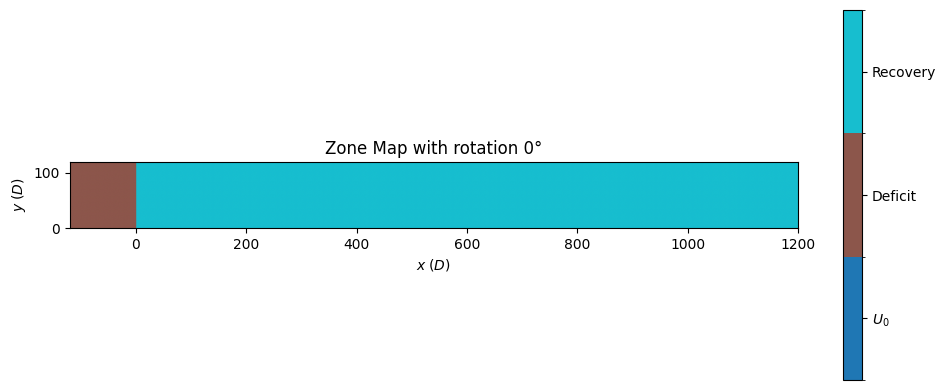

In [82]:
def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=0, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align rightmost (downstream) edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Align bottom of farm to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x and y bounds slightly
    x_padding = 0  # meters
    y_padding = 0  # meters
    min_x -= x_padding
    min_y -= y_padding
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)
    max_y += y_padding

    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range with extended domain
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points, radius=-1e-9)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range

# --- Define farm shape ---
corner_points = [(0, 0), (12000, 0), (12000, 12000), (0, 12000)]  # Rectangle
rotation_degrees = 0
mirror_axis = 'x'
recovery_x_end = RL # set recovery limit

# Generate mask
mask_2d, x_range, y_range = create_wind_farm_mask(
    corner_points,
    resolution=resolution,
    mirror_axis=mirror_axis,
    recovery_x_end=recovery_x_end  # pass to extend x_range
)

# --- Zone classification ---
ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2

zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]

    if true_indices.size == 0:
        # Ensure rows with no farm mask are cleared
        zone_map[row_idx] = ZONE_UH0
        continue

    if true_indices.size > 0:
        # Identify gaps between clusters of ones
        diffs = np.diff(true_indices)
        split_points = np.where(diffs > 1)[0]
        segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
        segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

        # Mark each deficit segment
        for start, end in zip(segment_starts, segment_ends):
            zone_map[row_idx, start:end + 1] = ZONE_DEFICIT

        # Mark gaps in between as recovery
        for i in range(len(segment_ends) - 1):
            gap_start = segment_ends[i] + 1
            gap_end = segment_starts[i + 1] - 1
            if gap_start <= gap_end:
                zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY

        # Mark recovery zone after the last deficit
        last_farm_x = x_range[segment_ends[-1]]
        recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
        zone_map[row_idx, recovery_indices] = ZONE_RECOVERY

zone_map1 = zone_map.copy()

# --- Improved Post-processing: Remove deficit after the last mask in each row ---
for i in range(zone_map.shape[0]):
    # Find last column with mask=1 (i.e. inside the farm)
    masked_cols = np.where(mask_2d[i] == 1)[0]
    if masked_cols.size == 0:
        continue
    last_valid_idx = masked_cols[-1]

    # Set all ZONE_DEFICIT values to ZONE_RECOVERY beyond the mask
    zone_map[i, last_valid_idx+1:] = np.where(
        zone_map[i, last_valid_idx+1:] == ZONE_DEFICIT,
        ZONE_RECOVERY,
        zone_map[i, last_valid_idx+1:]
    )

# Arbitrary TDM 

y_resolution = int(s_c / resolution)

results = []

# --- Guarantee 13 evenly spaced y points ---
# Get vertical farm extent from corner_points
farm_y_min = min(pt[1] for pt in corner_points)
farm_y_max = max(pt[1] for pt in corner_points)
farm_height = farm_y_max - farm_y_min

# Compute number of rows including both edges
num_y_points = int(farm_height / s_c) + 1  # ensures inclusive 0 and max

# Evenly spaced turbine row positions (absolute positions)
y_slice_values = np.linspace(farm_y_min, farm_y_max, num_y_points)

results = []

# For each y value, find the closest row index in the y_range
for y_val in y_slice_values:
    y_idx = np.argmin(np.abs(y_range - y_val))
    row = zone_map[y_idx]

    current_zone_type = row[0]
    start_idx = 0

    for idx in range(1, len(row) + 1):
        if idx == len(row) or row[idx] != current_zone_type:
            if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
                start_x = x_range[start_idx]
                end_x = x_range[idx - 1]
                zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})
            if idx < len(row):
                start_idx = idx
                current_zone_type = row[idx]
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})


# Initialize velocity profile collector with more data
final_velocity_data = []

current_y = None
i = 0

while i < len(results) - 1:
    zone1 = results[i]
    zone2 = results[i + 1]

    if zone1['type'] == 'deficit' and zone2['type'] == 'recovery' and zone1['y'] == zone2['y']:
        x_1 = zone1['start_x']
        x_2 = zone1['end_x']
        x_3 = zone2['end_x']
        y = zone1['y']

        if current_y != y:
            current_y = y
            previous_recovery_end_uw = U_0  # Set U_h0 as a constant 10 m/s

        x_shift = -x_1
        x_1 += x_shift
        x_2 += x_shift
        x_3 += x_shift
        effective_length = x_3 - x_1

        # Run Nygaard TDM
        x, U = calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_d, s_c)

        if effective_length < 10:
            print(f"⚠️ Skipping wake zone at y={y:.1f} — length too short ({effective_length:.2f} m)")
            i += 2
            continue

        deficit_end_uw = U[np.argmin(np.abs(x - x_2))]
        recovery_end_uw = U[-1]
        previous_recovery_end_uw = recovery_end_uw

        # Update or overwrite any previous entry for this y
        existing_idx = next((index for index, row in enumerate(final_velocity_data) if row[0] == y), None)
        new_entry = (y, recovery_end_uw, zone1['start_x'], zone1['end_x'])

        if existing_idx is not None:
            final_velocity_data[existing_idx] = new_entry
        else:
            final_velocity_data.append(new_entry)

        i += 2
    else:
        i += 1

# Convert to structured array: [y, final_velocity, x_start, x_end]
final_velocity_profile = np.array(sorted(final_velocity_data, key=lambda row: row[0]))

fig, axes = plt.subplots(figsize=(10, 4))

# --- Zone Map Plot ---
extent = [x_range[0]/D, x_range[-1]/D, y_range[0]/D, y_range[-1]/D]
cmap = mcolors.ListedColormap(['#1f77b4', '#8c564b', '#17becf'])  # Blue, Brown, Cyan
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = axes.imshow(zone_map, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='auto')
axes.set_title(f"Zone Map with rotation {rotation_degrees}°")
axes.set_xlabel(r"$x \; (D)$")
axes.set_ylabel(r"$y \; (D)$")
axes.set_aspect('equal')

# Optional colorbar
cbar = fig.colorbar(im, ax=axes, ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(['$U_0$', 'Deficit', 'Recovery'])

plt.tight_layout()
plt.show()

# Constants etc. for wakes

In [83]:
# Farm wake span
y_width = int(abs(np.max(corner_points, axis=0)[1] - np.min(corner_points, axis=0)[1]) + (RL / 5) * 2)
y = np.linspace(np.min(corner_points, axis=0)[1] - (RL / 5),
                np.max(corner_points, axis=0)[1] + (RL / 5),
                y_width)

# Row wake data
U_y = final_velocity_profile[:, 1]  # Wind speed
y0 = final_velocity_profile[:, 0]   # Center coord.
x2 = final_velocity_profile[:, 3]   # Start
x3 = RL                             # End

# Constants for Bastankhah
d0 = D
beta = 1/2 * (1 + np.sqrt(1 - C_T)) / np.sqrt(1 - C_T)
epsilon = 0.2 * np.sqrt(beta)

# Number of turbines in row
n_turbines = int(np.ceil(1 + (np.max(corner_points, axis=0)[0] - np.min(corner_points, axis=0)[0]) / (s_x * D)))

# Row wakes

In [84]:
def row_wake(x2, x3, y0, U_y):
    profile = np.zeros_like(y)

    k_star = 0.035

    u_s_array = []
    u_c_array = []
    u_0 = U_0 # Initialize perceived wind speed

    for i in range(n_turbines):

        # Wake length
        wl = x3 + n_turbines * s_d - i * s_d

        # Gaussian wake (Bastankhah)
        Cx = 1 - np.sqrt(1 - C_T / (8 * (k_star * wl/d0 + epsilon)**2))
        dU_U0 = Cx * np.exp(-1 / (2 * (k_star * wl/d0 + epsilon)**2) * ((y - y0) / d0)**2)

        # Linear sum
        profile += dU_U0
        
# ------------------------------------------------ Weighted sum (Zong) ----------------------------------------------- #
        print('u_0', u_0)

        u_s = Cx
        u_s_array.append(u_s)
        print('u_s', u_s)

        u_w = u_0 - u_s
        print('u_w', u_w)

        # GANGER i*s_d MED d0, IKKE RIGTIGT, MEN FOR AT UNDGÅ nan VÆRDIER FOR u_c
        sigma = d0 * ((k_star * i*s_d*d0) / d0 + epsilon)
        print('sigma', sigma)

        u_c = u_0 * (1/2 + 1/2 * np.sqrt(1 - C_T / (8*sigma/d0**2)))
        # Kan slettes når vi får den rigtige sigma (8.7 er fra chat fit til x=0)
        if not np.isnan(u_c):
            u_c_array.append(u_c)
        else:
            u_c_array.append(8.7)
        print('u_c', u_c)

        # Update perceived wind speed
        u_0 -= u_s

        print()
# ----------- Iteration ------------ #
    # Initialize U_c
    U_c = max(u_c_array)

    # Convert to numpy arrays
    u_s_array = np.array(u_s_array)
    u_c_array = np.array(u_c_array)

    # Iteration for convergence
    for _ in range(100):  # Max 100 iterations
        # (2.9) Update U_s
        U_s = np.sum((u_c_array / U_c) * u_s_array)

        # Update U_w
        U_w = U_0 - U_s

        # (2.7) Update U_c
        numerator = np.sum(U_w * U_s)
        denominator = np.sum(U_s)

        if denominator == 0:
            print("Warning: denominator is zero in U_c update.")
            break

        new_U_c = numerator / denominator

        # Check for convergence
        if np.abs(new_U_c - U_c) < 0.001:
            break

        U_c = new_U_c

    print("Final U_s:", U_s)
    print("Final U_c:", U_c)

    print("Weights:\n", u_c_array / U_c)
# -------------------------------------------------------------------------------------------------------------------- #

    return profile


# Farm wake

In [85]:
def farm_wake():
    profile = np.ones_like(y)

    for i in range(len(y0)):
        print(f'--- ROW NUMBER {i+1} ---')
        dU = row_wake(x2[i], RL, y0[i], U_y[i])
        profile -= dU

    return profile

# Plot farm wake

--- ROW NUMBER 1 ---
u_0 10
u_s 2.28245131737026e-05
u_w 9.999977175486826
sigma 25.44039299028138
u_c nan

u_0 9.999977175486826
u_s 2.3169744879814047e-05
u_w 9.999954005741946
sigma 3525.4403929902815
u_c 9.231844636152855

u_0 9.999954005741946
u_s 2.3522868959680032e-05
u_w 9.999930482872987
sigma 7025.440392990281
u_c 9.630452894393441

u_0 9.999930482872987
u_s 2.3884127831275137e-05
u_w 9.999906598745156
sigma 10525.440392990282
u_c 9.756485809149982

u_0 9.999906598745156
u_s 2.4253773292293168e-05
u_w 9.999882344971864
sigma 14025.440392990282
u_c 9.818364974320804

u_0 9.999882344971864
u_s 2.4632066958796273e-05
u_w 9.999857712904905
sigma 17525.440392990284
u_c 9.85513917241972

u_0 9.999857712904905
u_s 2.501928072817794e-05
u_w 9.999832693624176
sigma 21025.440392990284
u_c 9.879507390493284

u_0 9.999832693624176
u_s 2.541569726810522e-05
u_w 9.999807277926909
sigma 24525.440392990284
u_c 9.896838634952863

u_0 9.999807277926909
u_s 2.582161053221732e-05
u_w 9.999781456

C:\Users\Marcin\AppData\Local\Temp\ipykernel_2652\846446671.py:36: RuntimeWarning: invalid value encountered in sqrt
  u_c = u_0 * (1/2 + 1/2 * np.sqrt(1 - C_T / (8*sigma/d0**2)))


u_0 9.999755218990071
u_s 2.6663162780216076e-05
u_w 9.999728555827291
sigma 35025.44039299029
u_c 9.927863420464531

u_0 9.999728555827291
u_s 2.709945116519119e-05
u_w 9.999701456376126
sigma 38525.440392990284
u_c 9.934411488918563

u_0 9.999701456376126
u_s 2.7546536329747795e-05
u_w 9.999673909839796
sigma 42025.44039299029
u_c 9.939857313134386

Final U_s: 0.000317562429010179
Final U_c: 9.999680526315698
Weights:
 [0.8700278  0.92321396 0.96307606 0.97567975 0.98186787 0.9855454
 0.9879823  0.98971548 0.99101107 0.99201601 0.99281806 0.99347289
 0.99401749]
--- ROW NUMBER 11 ---
u_0 10
u_s 2.28245131737026e-05
u_w 9.999977175486826
sigma 25.44039299028138
u_c nan

u_0 9.999977175486826
u_s 2.3169744879814047e-05
u_w 9.999954005741946
sigma 3525.4403929902815
u_c 9.231844636152855

u_0 9.999954005741946
u_s 2.3522868959680032e-05
u_w 9.999930482872987
sigma 7025.440392990281
u_c 9.630452894393441

u_0 9.999930482872987
u_s 2.3884127831275137e-05
u_w 9.999906598745156
sigma 10525.

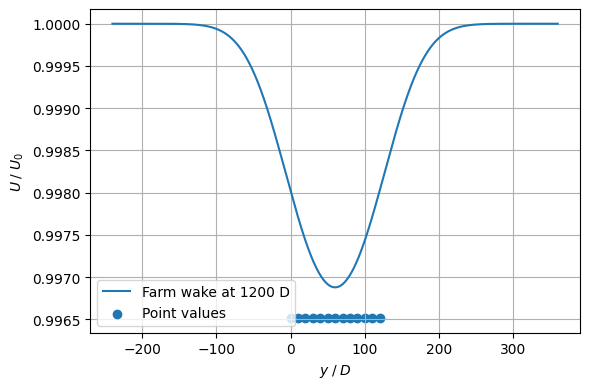

In [86]:
farm_profile = farm_wake()

plt.figure(figsize=(6, 4))
plt.plot(y / D, farm_profile, linestyle='-', label=f'Farm wake at {RL / D:.0f} D')
plt.scatter(y0 / D, U_y / U_0, label='Point values')
plt.xlabel(r'$y \; / \; D$')
plt.ylabel(r'$U \; / \; U_0$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [87]:
threshold = 0.99999
wake_indices = np.where(farm_profile < threshold)[0]

if wake_indices.size > 0:
    first_wake_idx = wake_indices[0]
    first_wake_y = y[first_wake_idx]
    print(f"First wake impact at {first_wake_y/D:.2f} D (index {first_wake_idx})")
else:
    print("No wake detected.")


First wake impact at -129.09 D (index 11091)


# Save to CSV

In [88]:
data = pd.DataFrame({
    "y_fine": y / D,
    "U_scaled": farm_profile,
})
data.to_csv(f"ValidationData/mREC{int(RL / D)}D.csv", index=False)